In [331]:
%matplotlib inline

import string
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_columns =50

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

from statistics import *
import concurrent.futures
import time
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from matplotlib.colors import ListedColormap
import seaborn as sns
color = sns.color_palette()

import nltk
from tqdm import tqdm
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import defaultdict

import unicodedata
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat

import re
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

In [332]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidkolb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [333]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

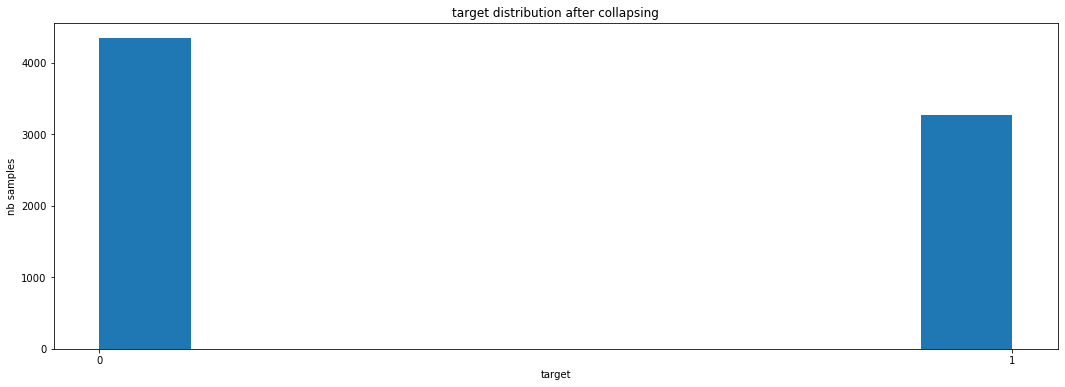

In [433]:
target = train['target']
plt.hist(target)
plt.xlabel('target')
plt.ylabel('nb samples')
plt.title('target distribution after collapsing')
plt.xticks(np.arange(len(np.unique(target))));

In [434]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 15 columns):
id                   7613 non-null int64
keyword              7552 non-null object
location             5080 non-null object
text                 7613 non-null object
target               7613 non-null int64
word_count           7613 non-null int64
unique_word_count    7613 non-null int64
stop_word_count      7613 non-null int64
url_count            7613 non-null int64
mean_word_length     7613 non-null float64
char_count           7613 non-null int64
punctuation_count    7613 non-null int64
hashtag_count        7613 non-null int64
mention_count        7613 non-null int64
text2                7613 non-null object
dtypes: float64(1), int64(10), object(4)
memory usage: 892.3+ KB


In [336]:
train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [337]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


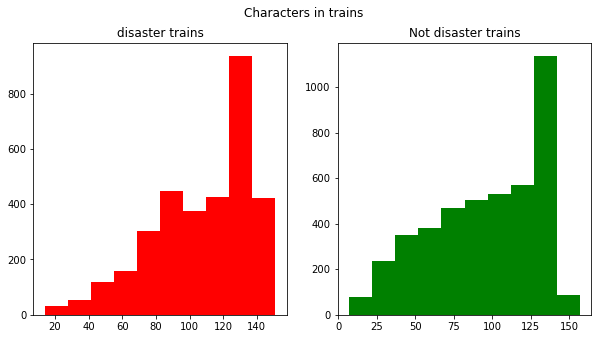

In [338]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.len()
ax1.hist(train_len,color='red')
ax1.set_title('disaster trains')
train_len=train[train['target']==0]['text'].str.len()
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster trains')
fig.suptitle('Characters in trains')
plt.show()

In [339]:
#Check missing train data ratios 
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head()

,Missing Ratio
location,33.272035
keyword,0.801261


In [340]:
#Check missing test data ratios 
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :test_na})
missing_data.head()

,Missing Ratio
location,33.864542
keyword,0.796813


In [341]:
#check for skewwness in data 
skewness = pd.DataFrame(train.skew(axis = 0, skipna = True).sort_values(ascending=False), columns=['Skew'])
skewness

,Skew
target,0.284243
id,0.007607


In [342]:
#Add meta data features
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [343]:
# fig =plt.figure(figsize=(15,15),dpi=100)
# sns.set_context('notebook',font_scale=1.3)
# sns.set_style('whitegrid')
# g=sns.pairplot(train[['word_count',
#                 'unique_word_count',
#                 'stop_word_count',
#                 'char_count',
#                 'target']],hue='target')

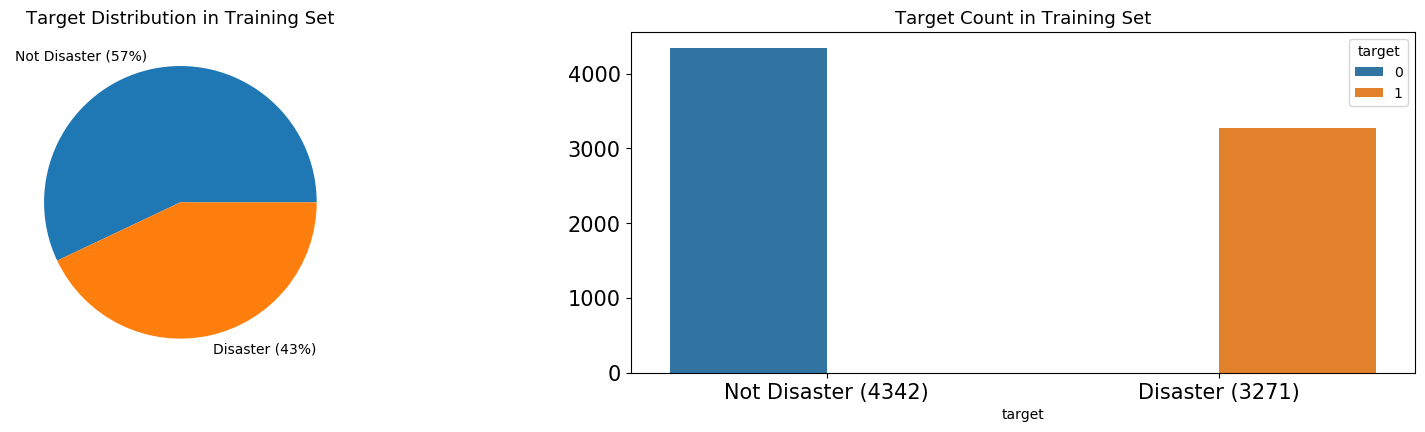

In [344]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [345]:
# N-gram analysis
def get_top_train_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

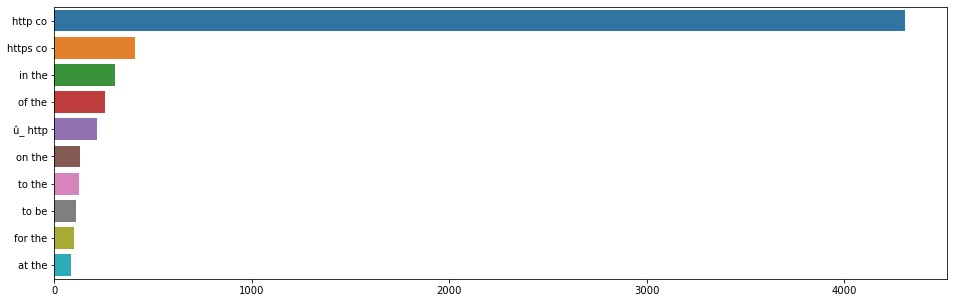

In [346]:
plt.figure(figsize=(16,5))
top_train_bigrams=get_top_train_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_train_bigrams))
sns.barplot(x=y,y=x)

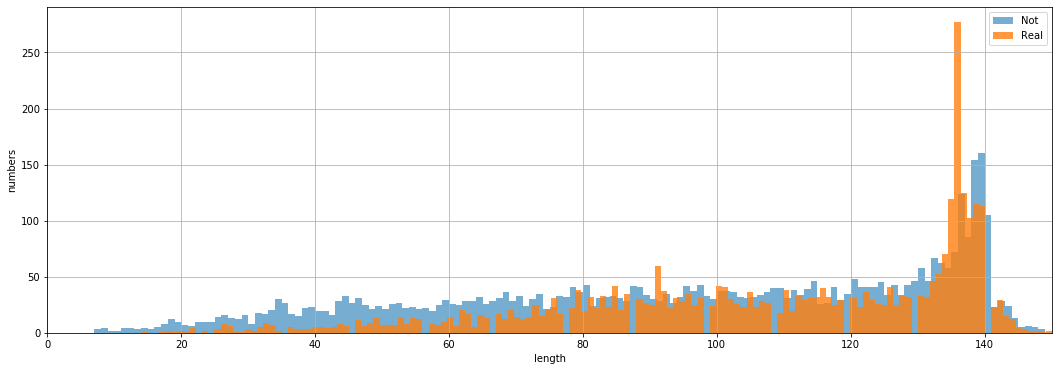

In [347]:
# Characters per tweet
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train[train['target'] == 0]['char_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['char_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

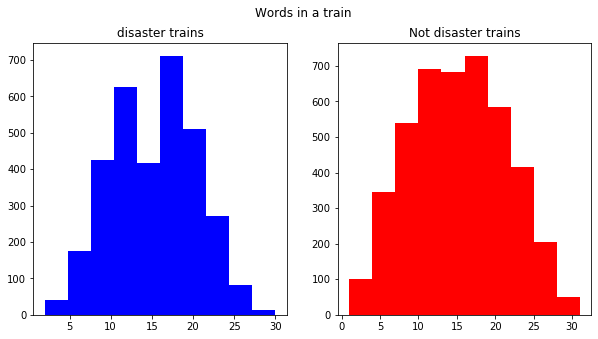

In [348]:
# Number of words in train
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('disaster trains')
train_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='red')
ax2.set_title('Not disaster trains')
fig.suptitle('Words in a train')
plt.show()

Text(0.5, 0.98, 'Average word length in each train')

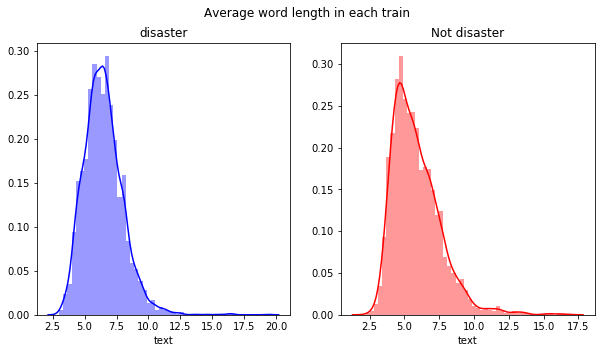

In [349]:
#Average word length in a train
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each train')

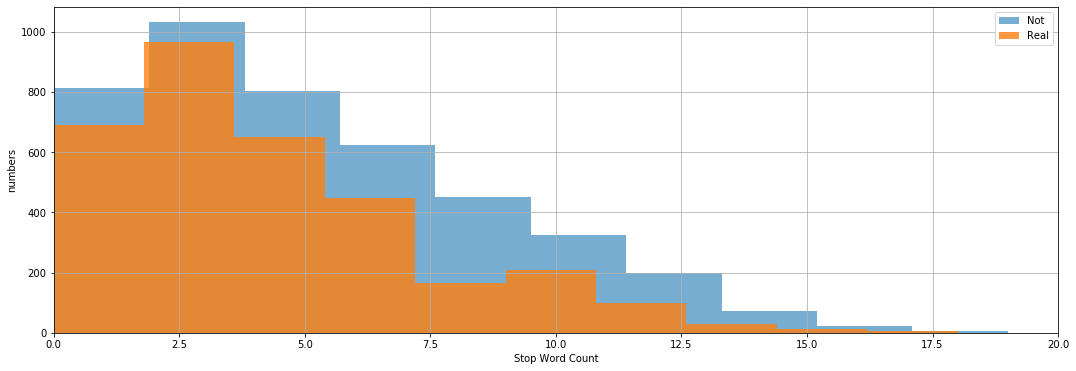

In [350]:
# stop_word_count
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(train[train['target'] == 0]['stop_word_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['stop_word_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('Stop Word Count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,20)
plt.grid()
plt.show()

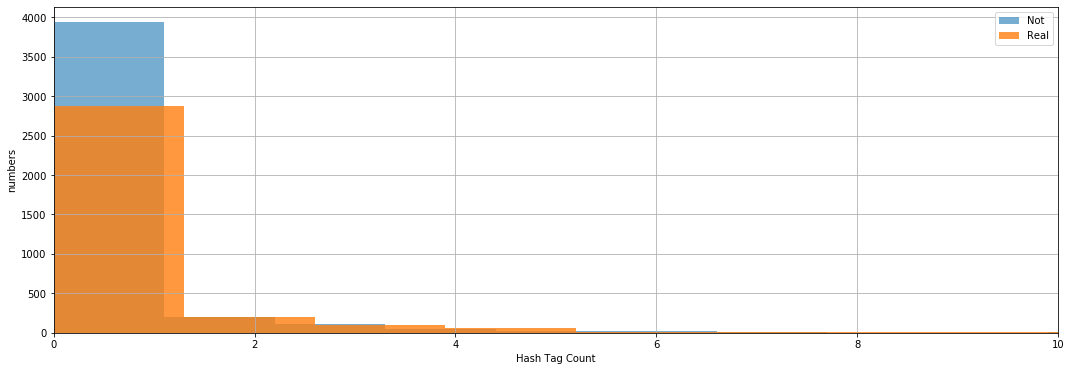

In [351]:
# hashtag_count
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(train[train['target'] == 0]['hashtag_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['hashtag_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('Hash Tag Count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,10)
plt.grid()
plt.show()

In [352]:
#Create a list of words
def create_corpus(target):
    corpus=[]
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#Create list of stop words
def stop_words(data):
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    return dic

#Create list of puntcuation
def punt_words(data):
    dic=defaultdict(int)
    special = string.punctuation
    for i in (corpus):
        if i in special:
            dic[i]+=1
    return dic

<BarContainer object of 10 artists>

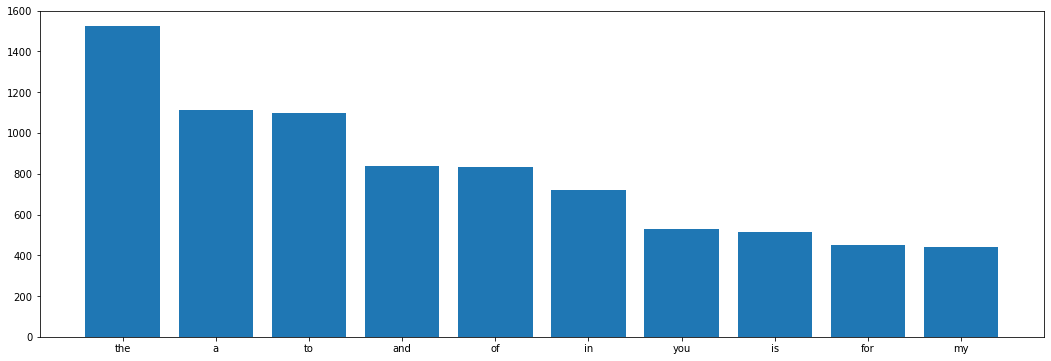

In [353]:
# Common stop words in class 0
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

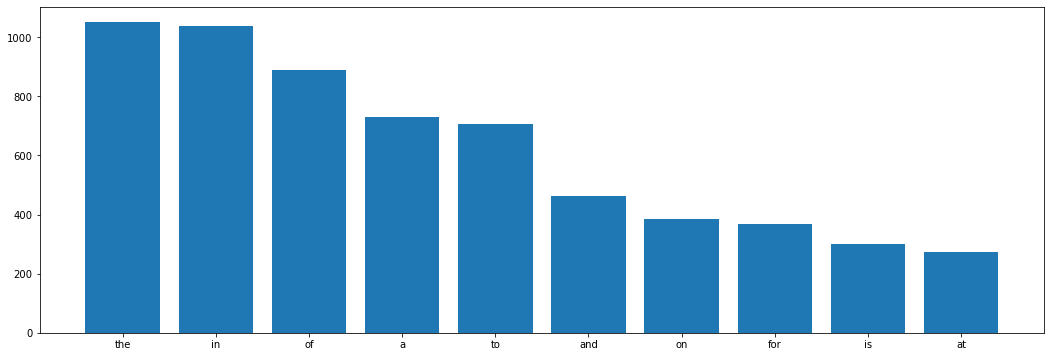

In [354]:
# Common stop words in class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

# Cleaing the Data

In [355]:
def remove_whitespace(data):
    return data.strip()

In [356]:
def remove_URL(data):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',data)

In [357]:
def remove_html(data):
    html=re.compile(r'<.*?>')
    return html.sub(r'',data)

In [358]:
def remove_emoji(data):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data)

In [359]:
def remove_accented_chars(data):
    return unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [360]:
def remove_punctuation(data):
    table=str.maketrans('','',string.punctuation)
    return data.translate(table)

In [361]:
def single_char(data):
    new_data=''
    for w in data:
        print(w)
        if len(w) > 1:
            print(w)
            new_data = new_data +  " " + w
    
    return new_data

In [362]:
def remove_special_characters(data, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    data = re.sub(pattern, '', data)
    return data

In [363]:
def convert_lower_case(data):
    return data.lower()

In [364]:
def tokenise(data):
    data = word_tokenize(data)
    return data

In [365]:
def remove_stop_words(data):
    filtered_sentence = [w for w in data if not w in stop_words] 
    return filtered_sentence

In [366]:
def stemming(data):
    data.apply(lambda x: [stemmer.stem(e) for e in x])
    return data

In [367]:
def lemmatise(data):
    lemmatizer = WordNetLemmatizer()
    data.apply(lambda x: [lemmatizer.lemmatize(e) for e in x])
    return data 

In [368]:
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer("english")

In [369]:
def nlp_clean(data):
    data = remove_URL(data)
    data = remove_html(data)
    data = remove_emoji(data)
    data = remove_whitespace(data)    
    data = remove_accented_chars(data) 
    data = remove_special_characters(data)
    data = remove_punctuation(data)
    data = convert_lower_case(data)
    return data
    
def nlp_tokenise(data):
    data = tokenise(data)
    data = remove_stop_words(data)
    return data
     
def nlp_normalise(data):
    data = stemming(data)
    data = lemmatise(data)
    return data

In [370]:
# Run preprossing steps to clean data
train['text']=train['text'].apply(lambda x : nlp_clean(x))
test['text']=test['text'].apply(lambda x : nlp_clean(x))

In [371]:
# Run steps to remove stop words
train['text']=train['text'].apply(lambda x : nlp_tokenise(x))
test['text']=test['text'].apply(lambda x : nlp_tokenise(x))

In [372]:
train['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                [m194, 0104, utc5km, volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [373]:
# Find and wordcloud common words
all_train_words = []
for text in train['text']:
    for word in text:
        all_train_words.append(word)

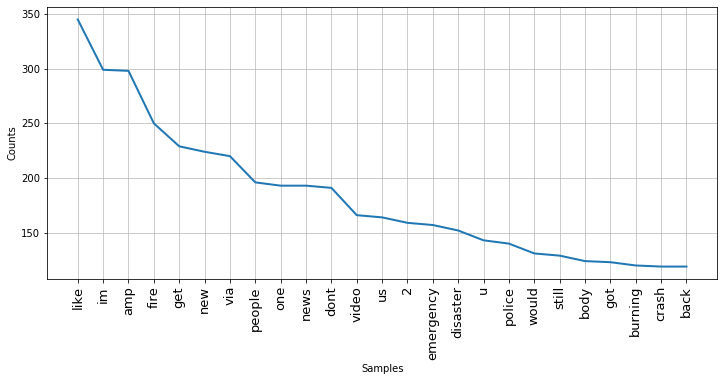

In [374]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_train_words)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(all_train_words).values(), reverse=True)

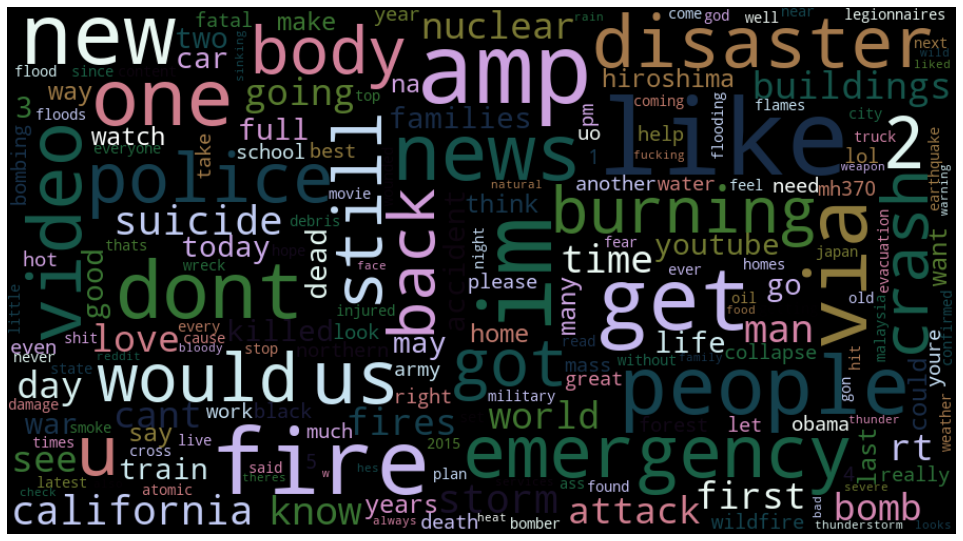

In [375]:
# create a word frequency dictionary
wordfreq = Counter(all_train_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='cubehelix_r',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [376]:
train['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                [m194, 0104, utc5km, volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [377]:
train['text2'] = train['text']
test['text2'] = test['text']

In [378]:
#Join Data
def combine_text(list_of_text):
    combined_text = ''
    for word in list_of_text:
        combined_text = combined_text + ' ' + word
    return combined_text

In [379]:
train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))

In [380]:
train['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2        residents asked shelter place notified office...
3        13000 people receive wildfires evacuation ord...
4        got sent photo ruby alaska smoke wildfires po...
                              ...                        
7608     two giant cranes holding bridge collapse near...
7609     ariaahrary thetawniest control wild fires cal...
7610                      m194 0104 utc5km volcano hawaii
7611     police investigating ebike collided car littl...
7612     latest homes razed northern california wildfi...
Name: text, Length: 7613, dtype: object

In [381]:
# List of models
model = pd.DataFrame(columns=['Model','Count','TFIDF'])

# count_vectorizer

In [382]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

In [383]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(train_vectors)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [384]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count_vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
# The lower the IDF value of a word, the less unique it is to any particular document.
df_idf.sort_values(by=['idf_weights'])

,idf_weights
like,4.141686
im,4.324616
amp,4.339322
fire,4.495326
get,4.521644
...,...
harvardu,9.244597
harvesting,9.244597
harveymaine,9.244597
harperanetflixshow,9.244597


In [385]:
# Compute the TFIDF score for your documents
count_vector=count_vectorizer.transform(train['text'])
 
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)

feature_names = count_vectorizer.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
 
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

#The more common the word across documents, the lower its score and 
#the more unique a word the higher the score

,tfidf
deeds,0.470046
forgive,0.470046
allah,0.406021
reason,0.366567
earthquake,0.326038
...,...
faith,0.000000
fake,0.000000
faked,0.000000
falcon,0.000000


# tfidf_vectorizer

In [386]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
train_tfidf = tfidf_vectorizer.fit_transform(train['text'])
test_tfidf = tfidf_vectorizer.transform(test['text'])
print(train_tfidf.shape)

(7613, 17915)


In [387]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=train_tfidf[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
deeds,0.470046
forgive,0.470046
allah,0.406021
reason,0.366567
earthquake,0.326038
...,...
faith,0.000000
fake,0.000000
faked,0.000000
falcon,0.000000


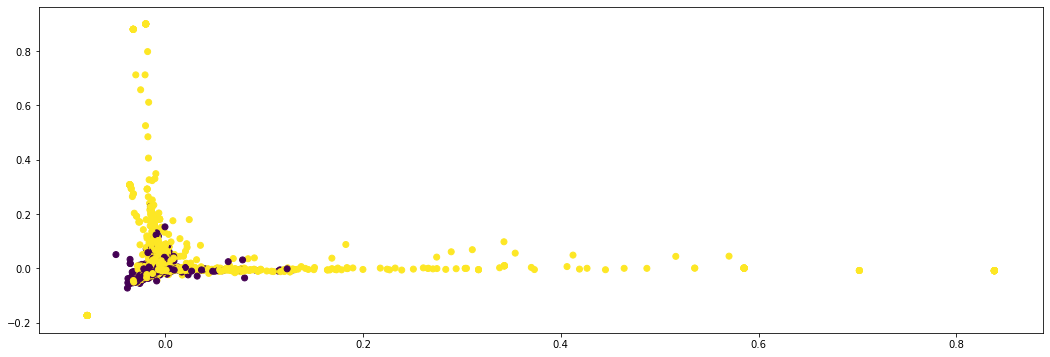

In [388]:
pca = PCA(n_components=2)
pca.fit(train_tfidf.todense())
data2D = pca.transform(train_tfidf.todense())
plt.scatter(data2D[:,0], data2D[:,1], c=train.target)
plt.show()  

# Logistic Regression Classifier

In [389]:
#Fitting on Counter Vectoriser
clf = LogisticRegression(C=1.0)
scorecount = model_selection.cross_val_score(clf, train_vectors, train['target'], cv=5, scoring='accuracy')

In [390]:
clf.fit(train_vectors, train['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [391]:
clf.score(train_vectors, train['target'])

0.9592801786417969

In [392]:
# Fitting on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scoretfidf = model_selection.cross_val_score(clf_tfidf, train_tfidf, train['target'], cv=5, scoring='accuracy')

In [393]:
clf_tfidf.fit(train_vectors, train['target'])
clf_tfidf.score(train_vectors, train['target'])

0.9592801786417969

In [394]:
model = model.append({'Model':'Logr',
                     'Count':scorecount.mean(),
                     'TFIDF':scoretfidf.mean()}, ignore_index=True)

# Naives Bayes Classifier

In [395]:
#Fitting on Counter Vectoriser
clf_NB = MultinomialNB()
scorecount = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring='accuracy')

In [396]:
clf_NB.fit(train_vectors, train['target'])
clf_NB.score(train_vectors, train['target'])

0.9160646262971234

In [397]:
# Fitting on TFIDF
clf_NB_TFIDF = MultinomialNB()
scoretfidf = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring='accuracy')

In [398]:
clf_NB_TFIDF.fit(train_vectors, train['target'])
clf_NB_TFIDF.score(train_vectors, train['target'])

0.9160646262971234

In [399]:
model = model.append({'Model':'Bayes',
                     'Count':scorecount.mean(),
                     'TFIDF':scoretfidf.mean()}, ignore_index=True)

# XGBoost

In [400]:
# #Fitting on Counter Vectoriser
# clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
#                         subsample=0.8, nthread=10, learning_rate=0.1)
# scorecount = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring='accuracy')

KeyboardInterrupt: 

In [ ]:
# # Fitting on TFIDF
# clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
#                         subsample=0.8, nthread=10, learning_rate=0.1)
# scoretfidf = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring='accuracy')

In [ ]:
# model = model.append({'Model':'XGB',
#                      'Count':scorecount.mean(),
#                      'TFIDF':scoretfidf.mean()}, ignore_index=True)

In [401]:
model

,Model,Count,TFIDF
0,Logr,0.685536,0.703534
1,Bayes,0.703932,0.722718


In [416]:
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=len_input_train))
model_lstm2.add(LSTM(units))
model_lstm2.add(Dense(1, activation='sigmoid'))
model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm2 = model_lstm2.fit(input_data_train, labels, epochs=10, batch_size=BATCH_SIZE)


NameError: name 'vocab_in_size' is not defined

# BERT

In [467]:
#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [471]:
device = torch.device('cpu')

In [403]:
sentences = train['text'].apply(lambda x: str('[CLS]' + x + '[SEP]'))
sentences

0       [CLS] deeds reason earthquake may allah forgiv...
1        [CLS] forest fire near la ronge sask canada[SEP]
2       [CLS] residents asked shelter place notified o...
3       [CLS] 13000 people receive wildfires evacuatio...
4       [CLS] got sent photo ruby alaska smoke wildfir...
                              ...                        
7608    [CLS] two giant cranes holding bridge collapse...
7609    [CLS] ariaahrary thetawniest control wild fire...
7610           [CLS] m194 0104 utc5km volcano hawaii[SEP]
7611    [CLS] police investigating ebike collided car ...
7612    [CLS] latest homes razed northern california w...
Name: text, Length: 7613, dtype: object

In [404]:
train_char = train['text'].apply(lambda x: len(str(x))).max()
test_char = test['text'].apply(lambda x: len(str(x))).max()
train_char

139

In [405]:
target

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

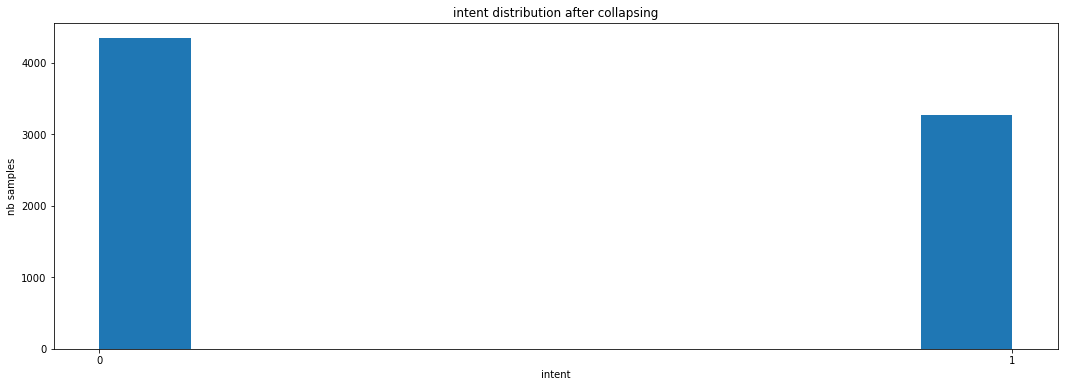

In [406]:
plt.hist(target)
plt.xlabel('intent')
plt.ylabel('nb samples')
plt.title('intent distribution after collapsing')
plt.xticks(np.arange(len(np.unique(target))));

In [444]:
target.ravel()

array([1, 1, 1, ..., 1, 1, 1])

In [411]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [417]:
# BERT requires input ids, a sequence of integers identifying each input token 
# to its index number in the BERT tokenizer vocabulary.

# Set the maximum sequence length. 
MAX_LEN = 140
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [418]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [445]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, target.ravel(), 
                                                            random_state=40, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=40, test_size=0.1)

In [447]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [456]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [472]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
    
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [206]:
pred = clf_NB_TFIDF.predict(test_tfidf)

In [212]:
output=pd.DataFrame({'id':test.id, 'target':pred})
output.to_csv('DSKsubmission.csv', index=False)

In [213]:
output

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


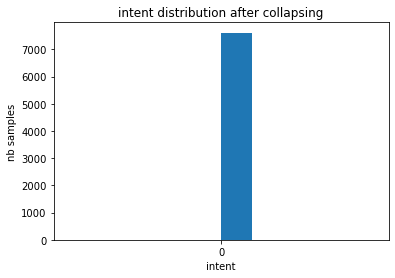

0       0
1       0
2       0
3       0
4       0
       ..
7608    0
7609    0
7610    0
7611    0
7612    0
Name: target, Length: 7613, dtype: int64